In [1]:
# import python packages to use for analysis
import numpy as np
import pandas as pd
import os
import glob
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy.stats import norm
import ast
Z = norm.ppf

# stuff for fitting pphys
import sys
# insert at 1, 0 is the script path (or '' in REPL)
!pip install https://github.com/wichmann-lab/python-psignifit/zipball/master
import psignifit as ps

     / 57 kB 1.2 MB/s/s
  Created wheel for psignifit: filename=psignifit-0.1-py3-none-any.whl size=52888 sha256=4214d909085629411eec7a8c8115585f212d47385898b804fe022c0ddb134aef
  Stored in directory: /private/var/folders/d5/x8txhspx6g51f4gnfx3cbc3w0000gp/T/pip-ephem-wheel-cache-_1yj1dot/wheels/4d/7d/54/d8cdbe564ea209f71735cc1b54329a6ab336d28a1e6c99df87
Successfully built psignifit


In [2]:
data_dir = ["./data"]

# define empty lists that will hold the number of subjects, rejected subjects and test subjects
sub_count = [0]*len(data_dir)    # included datasets
reject_count = [0]*len(data_dir) # complete datasets, but rejected due to performance
test_count = [0]*len(data_dir)   # incomplete test datasets

complete_subs = [] # subjects that produced complete datasets

prac_n = 16 # number of practice trials
exp_n = 160 # number of experiment trials

info_df = pd.DataFrame()

for e, cur_dir in enumerate(data_dir):
    file_list = glob.glob(cur_dir + "/psyc4260*.csv") + glob.glob(cur_dir + "/nrsc2200*.csv")
    file_list.sort()
    exp_subs = [] # list to hold the subjects in this experiment
    for file in file_list:
        # load the data
        try:
            sub_data = pd.read_csv(file)
            if "trial_type" not in sub_data:
                sub_data = pd.read_csv(file, skiprows=1)
            # in the past, some trials were duplicated in the data file, the code below takes care of that
            sub_data = sub_data[sub_data['trial_index'].apply(lambda x: str(x).isdigit())]
            sub_data = sub_data.drop_duplicates()
        except:
            print("Failed to load file {0}".format(file.split(cur_dir)[1]))
            
        # get id
        try:
            survey_resp = sub_data[sub_data["trial_type"]=="survey-html-form"].loc[0]["response"]
            survey_resp = survey_resp.replace(':"}',':""}')
            sub_info = ast.literal_eval(survey_resp)
        except:
            sub_info = {}
        # see if id was stored
        if 'p_id' in sub_info.keys():
            # if participant ID was recorded, use it to get rid of data with test subject ID 214984
            # this is the ID associated with URPP's sample link
            try:    
                sub_id = sub_info["p_id"]
            except:
                sub_id = "nan"
            del sub_info['p_id']
            if sub_id in ["214984", "603921b616b3893be91674d1"]:
                test_count[e] = test_count[e] + 1
                continue
        else:
            sub_id = "nan"
        # do quality control on the data
        if sub_data.shape[1] < 10:
            print(e, sub_id, "incomplete file, shape:{0}x{1}".format(sub_data.shape[0],sub_data.shape[1]))
            test_count[e] = test_count[e] + 1 # record test subject to the test_count, by adding 1 at the relevant position
            continue
        
        # now skip if this subjects data is already in the set
        if sub_id in exp_subs:
            continue
        
        # add participant to list of subjects for this experiment
        exp_subs.append(sub_id)
        
        # start populating sub_info dict: 
        sub_info["experiment"] = e
        sub_info["ID"] = sub_id

        # Cognition.run specific error: replace strings with logicals
        sub_data = sub_data.replace("true", True)
        sub_data = sub_data.replace("false", False)
        
        pphys_data = sub_data[sub_data["trial_type"] == "psychophysics"]
        pphys_data = pphys_data.replace(np.nan, "")
        pphys_data = pphys_data.replace('"', "")
        pphys_data = pphys_data[pphys_data.test_inner_radius != ""]
        pphys_data = pphys_data.astype(
            {"test_inner_radius": 'int', "test_outer_radius": 'int', "ref_inner_radius": 'int', "ref_outer_radius": 'int' })
        
        test_inner_sizes = [x for x in pphys_data["test_inner_radius"].unique()]
        test_inner_sizes.sort()
        
        test_outer_sizes = [x for x in pphys_data["test_outer_radius"].unique()]
        test_outer_sizes.sort()
        
        ref_outer_size = [x for x in pphys_data["ref_outer_radius"].unique()][0]
        ref_inner_size = [x for x in pphys_data["ref_inner_radius"].unique()][0]
     
        for size in test_inner_sizes:
            for o in test_outer_sizes:
                cur_data = pphys_data[(pphys_data["test_inner_radius"]==size) & (pphys_data["test_outer_radius"]==o)]
                if o == ref_outer_size:
                    sub_info["rt-same-"+str(size)] = cur_data["rt"].mean()
                    temp_bigger = cur_data["test_bigger"]
                    sub_info["testbigger-same-" + str(size) ] = np.nansum(temp_bigger)/len(temp_bigger)
                    sub_info["ntrials-same-" + str(size) ] = len(temp_bigger)
                else:
                    sub_info["rt-small-"+str(size)] = cur_data["rt"].mean()
                    temp_bigger = cur_data["test_bigger"]
                    sub_info["testbigger-small-" + str(size) ] = np.nansum(temp_bigger)/len(temp_bigger)
                    sub_info["ntrials-small-" + str(size) ] = len(temp_bigger)

        sub_count[e] = sub_count[e]+1
        sub_info["count"] = sub_count[e]
        info_df = pd.concat([info_df, pd.json_normalize(sub_info)], sort=False)

        # add to dataframe of complete subjects 
        complete_subs.append(exp_subs)
info_df = info_df.set_index("count")

In [3]:
cols = info_df.columns.tolist()
cols.sort()
cols.insert(0, cols.pop(cols.index("experiment")))
if "age" in cols:
    cols.insert(2, cols.pop(cols.index("age")))
    cols.insert(3, cols.pop(cols.index("handedness")))
    cols.insert(4, cols.pop(cols.index("sex")))
    cols.insert(5, cols.pop(cols.index("other_sex")))
info_df = info_df[cols]
info_df = info_df.sort_values(by = ["experiment", "ID"] )

In [4]:
# FIT DATA 
fit_params = [ [], [] ]
pse_slope = [ [], [] ]
options = dict();   # initialize as an empty dictionary
options['sigmoidName'] = 'norm';   # choose a cumulative Gauss as the sigmoid  
options['expType']     = 'equalAsymptote';   # choose 2-AFC as the experiment type  
                                   # this sets the guessing rate to .5 (fixed) and  
                                   # fits the rest of the parameters
for d, data_type in enumerate(["same", "small"]):
    for index, row in info_df.iterrows():
        # same inducers
        fit_data = [ row[x] for x in info_df.columns if x.startswith("testbigger-{0}-".format(data_type)) ]
        n_trials = [ row[x] for x in info_df.columns if x.startswith("ntrials-{0}-".format(data_type)) ]
        fit_data = np.vstack([np.array(test_inner_sizes), np.array(fit_data)*np.array(n_trials), np.array(n_trials)])
        temp_params = ps.psignifit(fit_data.transpose(),options)
        fit_params[d].append(temp_params)
        pse_slope[d].append((ps.getThreshold(temp_params,.5)[0], ps.getSlopePC(temp_params,.5)))
    # run fit on averages for illustration purposes
    fit_data = [ info_df[x].mean() for x in info_df.columns if x.startswith("testbigger-{0}-".format(data_type)) ]
    n_trials = [ int(info_df[x].mean()) for x in info_df.columns if x.startswith("ntrials-{0}-".format(data_type)) ]
    fit_data = np.vstack([np.array(test_inner_sizes), np.array(fit_data)*np.array(n_trials), np.array(n_trials)])
    temp_params = ps.psignifit(fit_data.transpose(),options)
    fit_params[d].append(temp_params)
    # assign pses to info_df
    pse_slope[d].append((ps.getThreshold(temp_params,.5)[0], ps.getSlopePC(temp_params,.5)))
    info_df["pse-{0}".format(data_type)] = [ x[0] for x in pse_slope[d][0:-1] ]
    info_df["pse-{0}-avefit".format(data_type)] = [pse_slope[d][-1][0]] * info_df.shape[0]
    info_df["slope-{0}".format(data_type)] = [ x[1] for x in pse_slope[d][0:-1] ]
    info_df["slope-{0}-avefit".format(data_type)] = [pse_slope[d][-1][1]] * info_df.shape[0]

(array([], dtype=int64),)


/Users/kohler/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/kohler/anaconda3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


/Users/kohler/anaconda3/lib/python3.7/site-packages/psignifit/likelihood.py:191: RuntimeWarning: divide by zero encountered in log
  pbin = pbin  + (ni-ki)*np.log(1-psi)


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/Users/kohler/anaconda3/lib/python3.7/site-packages/psignifit/likelihood.py:121: RuntimeWarning: divide by zero encountered in log
  p = p + k * np.log(psi) + (n-k)*np.log(1-psi)   # binomial model
/Users/kohler/anaconda3/lib/python3.7/site-packages/psignifit/likelihood.py:121: RuntimeWarning: invalid value encountered in multiply
  p = p + k * np.log(psi) + (n-k)*np.log(1-psi)   # binomial model
/Users/kohler/anaconda3/lib/python3.7/site-packages/psignifit/likelihood.py:127: RuntimeWarning: invalid value encountered in subtract
  p = p -sp.gammaln(n+v) - sp.gammaln(a) - sp.gammaln(b)


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [5]:
# save data
info_df.to_csv("./data/ebbinghaus_combined.csv")

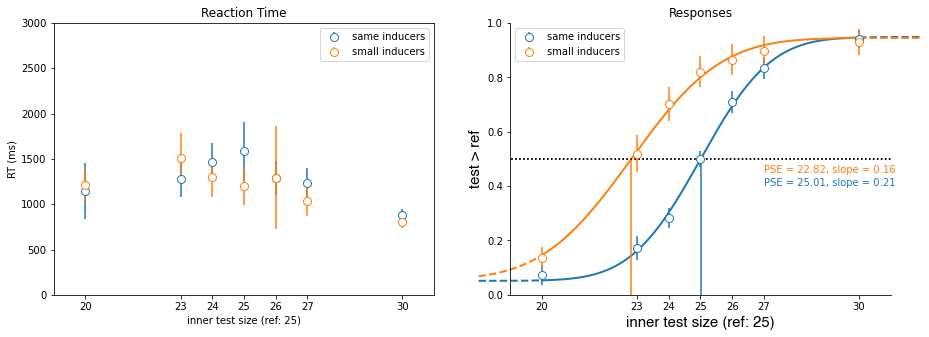

In [6]:
# plot data from two experiments
condition_list = ["same", "small"]

ps_kwargs = dict(plotData=False, showImediate=False, plotAsymptote=False)
eb_kwargs = dict(linestyle='none', marker='o', mfc='w', ms=8, clip_on=False)

fig, ax = plt.subplots(1,2, figsize=[15,5])
for t, data_type in enumerate(["rt", "testbigger"]):
    for c, cond in enumerate(condition_list):
        means = [info_df["{0}-{1}-{2}".format(data_type, cond, str(x))].mean() for x in test_inner_sizes]
        stddev = [info_df["{0}-{1}-{2}".format(data_type, cond, str(x))].std() for x in test_inner_sizes]
        n = [info_df["{0}-{1}-{2}".format(data_type, cond, str(x))].count() for x in test_inner_sizes]
        stderr = [i / np.sqrt(j) for i, j in zip(stddev, n)]
        ci = [x * 1.96 for x in stderr]
        e_h = ax[t].errorbar(test_inner_sizes, means, yerr=ci, label=condition_list[c]+ " inducers", **eb_kwargs)
        ax[t].set_xticks(test_inner_sizes)
        
        if data_type == 'rt':
            ax[t].set_ylim([0,3000])
        else:
            ax[t].set_ylim([0,1])
        if "testbigger" in data_type:
            title_str = 'Responses'
            ylabel_str = "test > ref"
            many_xx = np.linspace(20, 30)
            ps.psigniplot.plotPsych(fit_params[c][-1],axisHandle=ax[t],lineColor=e_h[0].get_color(), **ps_kwargs)
            ax[t].plot((10, 40), (0.5, 0.5), 'k:')
            cur_pse = info_df["pse-{0}-avefit".format(cond)].to_list()[0]
            cur_slope = info_df["slope-{0}-avefit".format(cond)].to_list()[0]
            if cond is "same":
                ax[t].text(27, 0.40, "PSE = {:.2f}, slope = {:.2f}".format(cur_pse, cur_slope), color=e_h[0].get_color())
            else:
                ax[t].text(27, 0.45, "PSE = {:.2f}, slope = {:.2f}".format(cur_pse, cur_slope), color=e_h[0].get_color())
        else:
            title_str = 'Reaction Time'
            ylabel_str = "RT (ms)"
        ax[t].set_xlim([19,31])  
            
        ax[t].set_xlabel("inner test size (ref: 25)")
        ax[t].set_ylabel(ylabel_str)
        ax[t].title.set_text(title_str)
        ax[t].legend()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=302822b2-b758-49ed-8f0c-200a4a578026' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [8]:
temp_params

{'X1D': [array([17.06896552, 17.28116711, 17.4933687 , 17.70557029, 17.91777188,
         18.12997347, 18.34217507, 18.55437666, 18.76657825, 18.97877984,
         19.19098143, 19.40318302, 19.61538462, 19.82758621, 20.0397878 ,
         20.25198939, 20.46419098, 20.67639257, 20.88859416, 21.10079576,
         21.31299735, 21.52519894, 21.73740053, 21.94960212, 22.16180371,
         22.37400531, 22.5862069 , 22.79840849, 23.01061008, 23.22281167,
         23.43501326, 23.64721485, 23.85941645, 24.07161804, 24.28381963,
         24.49602122, 24.70822281, 24.9204244 , 25.13262599, 25.34482759]),
  array([ 1.        ,  1.68639053,  2.37278107,  3.0591716 ,  3.74556213,
          4.43195266,  5.1183432 ,  5.80473373,  6.49112426,  7.17751479,
          7.86390533,  8.55029586,  9.23668639,  9.92307692, 10.60946746,
         11.29585799, 11.98224852, 12.66863905, 13.35502959, 14.04142012,
         14.72781065, 15.41420118, 16.10059172, 16.78698225, 17.47337278,
         18.15976331, 18.8461